In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.7, style='whitegrid') 

In [2]:
ekin = np.loadtxt("Code/4.1/output_ekin.dat")
temp = np.loadtxt("Code/4.1/output_temp.dat")
epot = np.loadtxt("Code/4.1/output_epot.dat")
etot = np.loadtxt("Code/4.1/output_etot.dat")

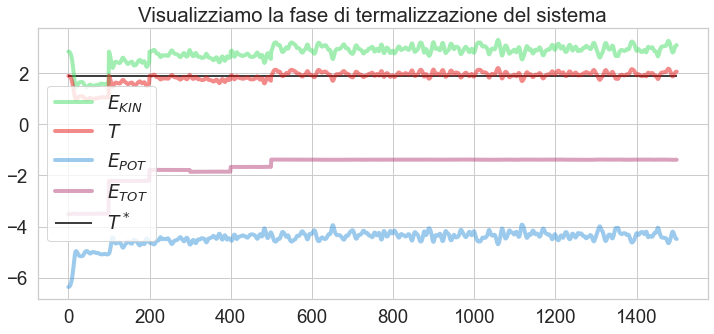

In [3]:
plt.figure(figsize=(12,5))
plt.title('Visualizziamo la fase di termalizzazione del sistema')
plt.plot(ekin, label='$E_{KIN}$', color='#44dd66', linewidth=4, alpha=0.5)
plt.plot()
plt.plot(temp, label='$T$', color='#e81717', linewidth=4, alpha=0.5)
plt.hlines(1.9, 0, 1500, color='black', label='$T^*$', alpha=1)
plt.plot(epot, label='$E_{POT}$', color='#3a96dc', linewidth=4, alpha=0.5)
plt.plot(etot, label='$E_{TOT}$', color='#b7457d', linewidth=4, alpha=0.5)
plt.legend()
plt.show()

## Solido

In [39]:
temp = np.loadtxt("Code/4.3/Risultati_belli/T_solid.dat")
ave_res = np.loadtxt("Code/4.3/Risultati_belli/ave_results_solid.dat")

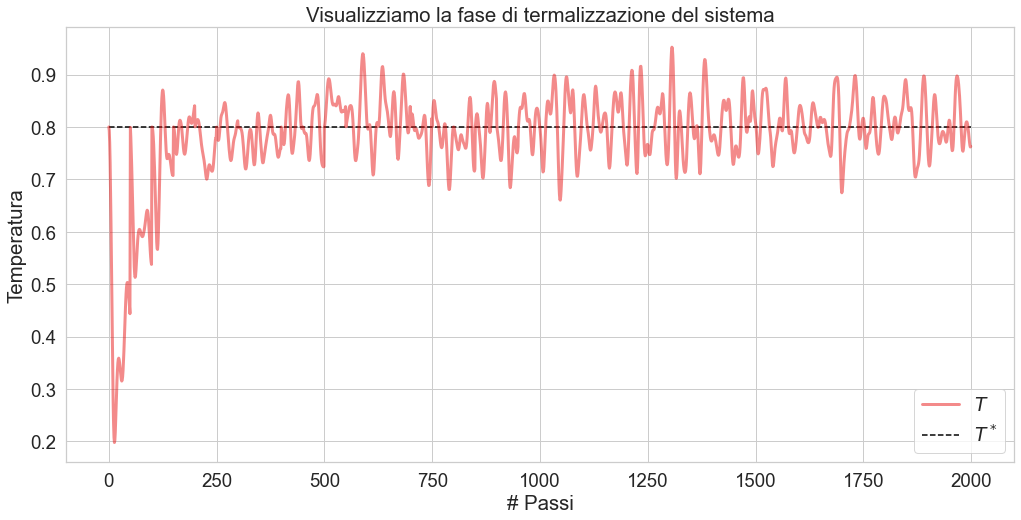

In [40]:
plt.figure(figsize=(17,8))
plt.title('Visualizziamo la fase di termalizzazione del sistema')
plt.plot()
plt.plot(temp, label='$T$', color='#e81717', linewidth=3, alpha=0.5)
plt.hlines(0.8, 0, 2000, color='black', label='$T^*$', alpha=1, linestyle='--')
plt.legend()
plt.xlabel("# Passi")
plt.ylabel("Temperatura")
plt.savefig('therm.png')
plt.show()

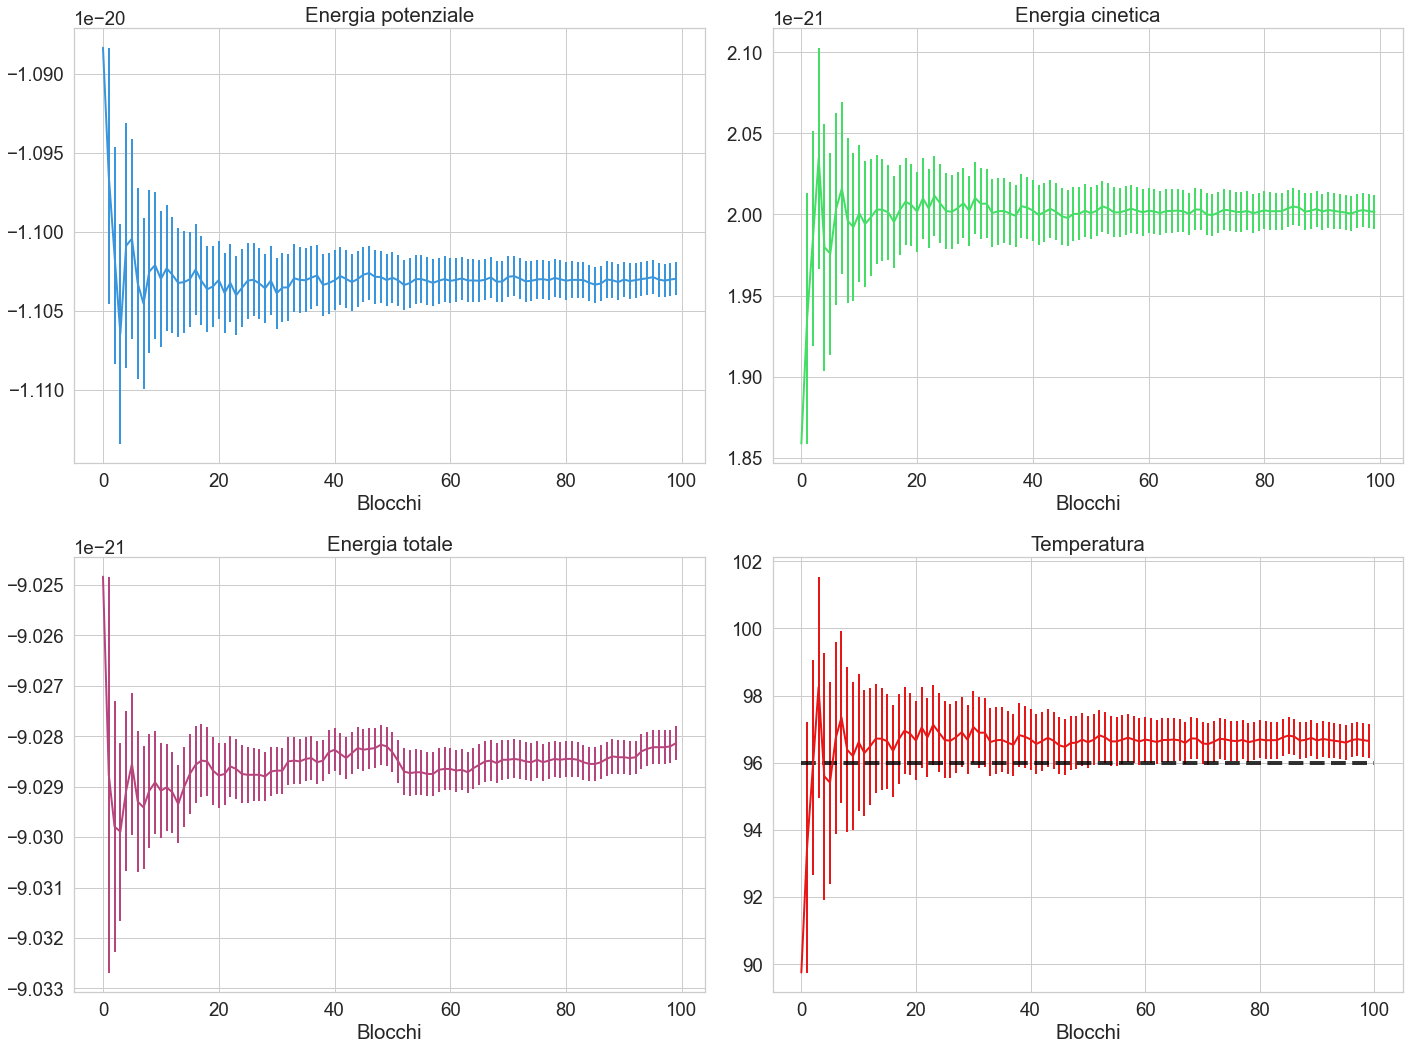

In [41]:
x = np.arange(100)
titles = ['Energia potenziale', 'Energia cinetica', 'Energia totale', 'Temperatura']
colors = [ '#3a96dc', '#44dd66' ,'#b7457d','#e81717']

K_B = 1.380649e-23
eps = 120*K_B
m   = 39.948*1.66054e-27

T_star = 120*0.8

fs = [eps, eps, eps, eps/K_B]
#fs = [1,1,1,1]
plt.figure(figsize=(20,15))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(titles[i])
    plt.errorbar(x, ave_res.T[i*2]*fs[i], yerr=ave_res.T[i*2+1]*fs[i], color=colors[i], alpha=1, linewidth=2)
    if(i==3):
        plt.hlines(T_star, 0, 100, color='black', linewidth=4, alpha=0.8, linestyle='--')
    plt.xlabel('Blocchi')

plt.tight_layout()
plt.show()

## Liquido

In [42]:
temp = np.loadtxt("Code/4.3/T_liquid.dat")
ave_res = np.loadtxt("Code/4.3/ave_results_liquid.dat")

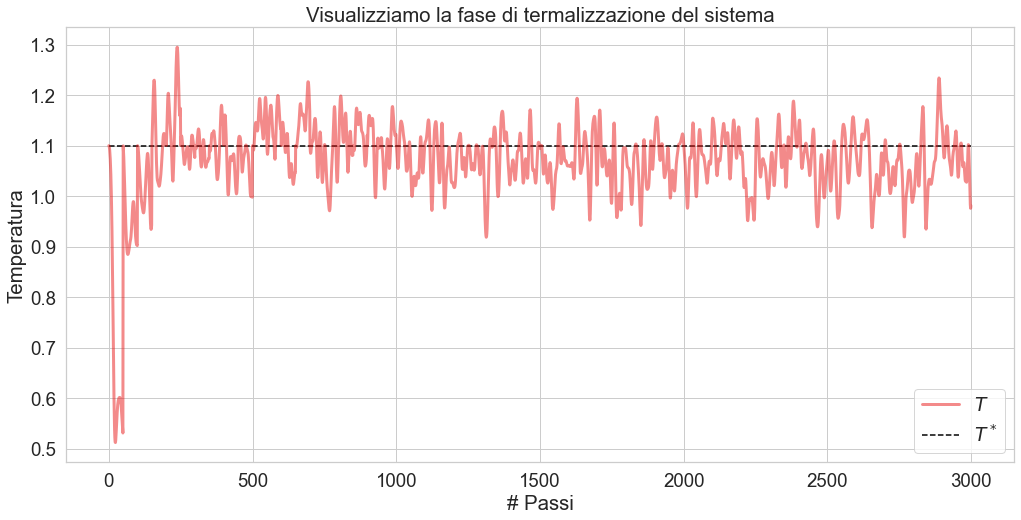

In [43]:
plt.figure(figsize=(17,8))
plt.title('Visualizziamo la fase di termalizzazione del sistema')
plt.plot()
plt.plot(temp, label='$T$', color='#e81717', linewidth=3, alpha=0.5)
plt.hlines(1.1, 0, 3000, color='black', label='$T^*$', alpha=1, linestyle='--')
plt.legend()
plt.xlabel("# Passi")
plt.ylabel("Temperatura")
plt.savefig('therm.png')
plt.show()

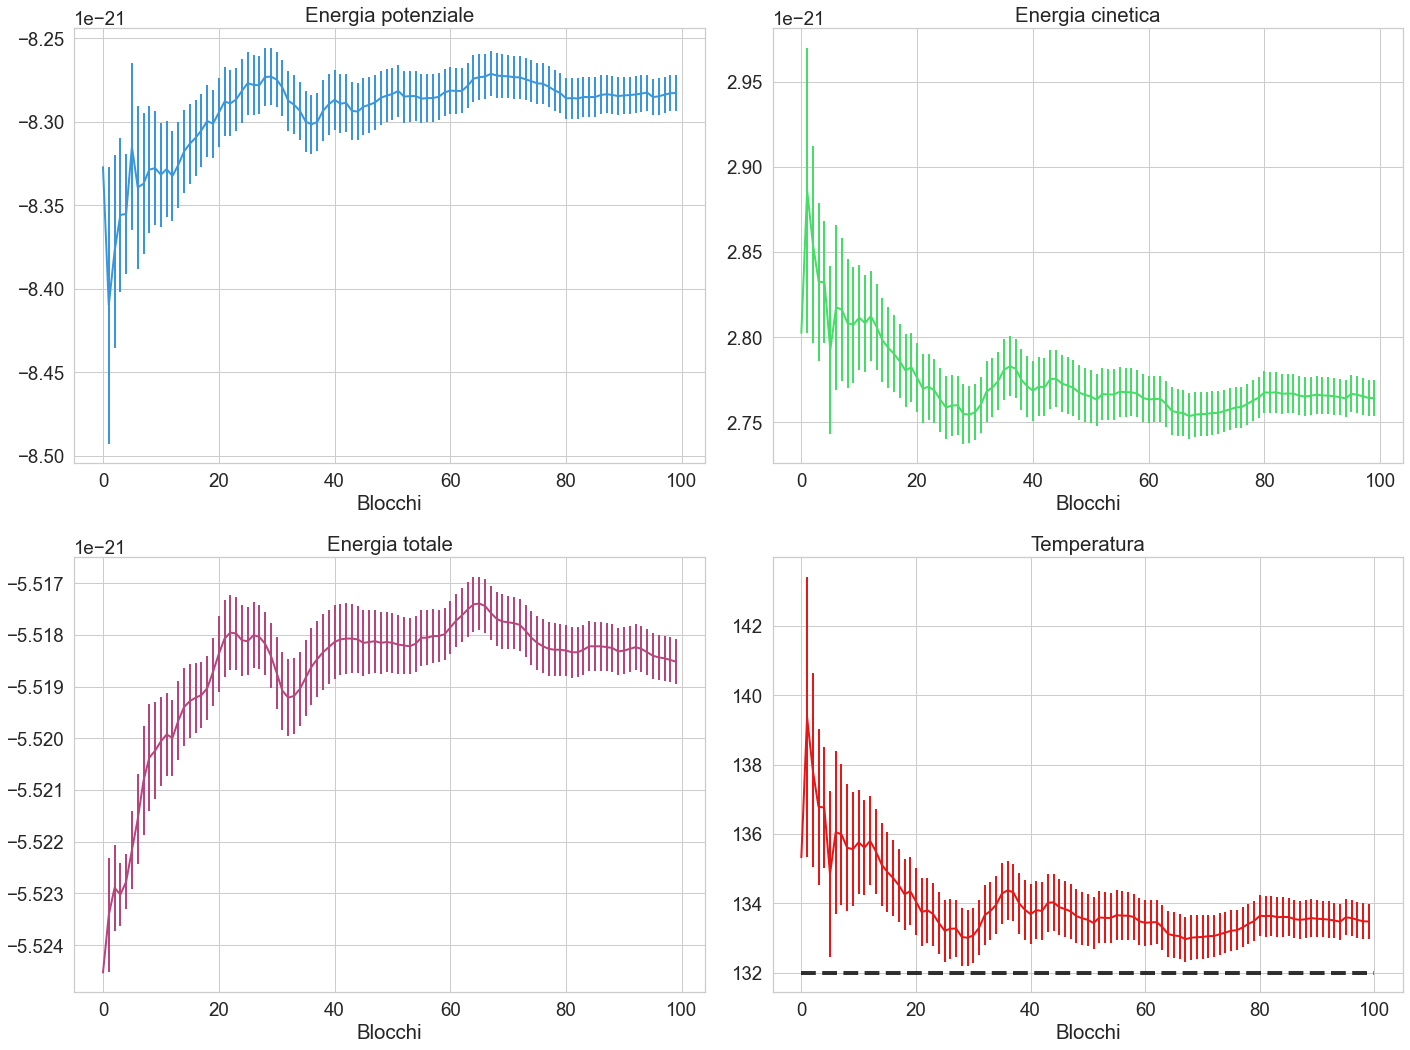

In [44]:
plt.figure(figsize=(20,15))

T_star = 120*1.1

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(titles[i])
    plt.errorbar(x, ave_res.T[i*2]*fs[i], yerr=ave_res.T[i*2+1]*fs[i], color=colors[i], alpha=1, linewidth=2)
    if(i==3):
        plt.hlines(T_star, 0, 100, color='black', linewidth=4, alpha=0.8, linestyle='--')
    plt.xlabel('Blocchi')

plt.tight_layout()
plt.show()

## Gas

In [54]:
temp = np.loadtxt("Code/4.3/T_gas.dat")
#temp = np.loadtxt("Code/4.3/output_temp.dat")
ave_res = np.loadtxt("Code/4.3/ave_results_gas.dat")

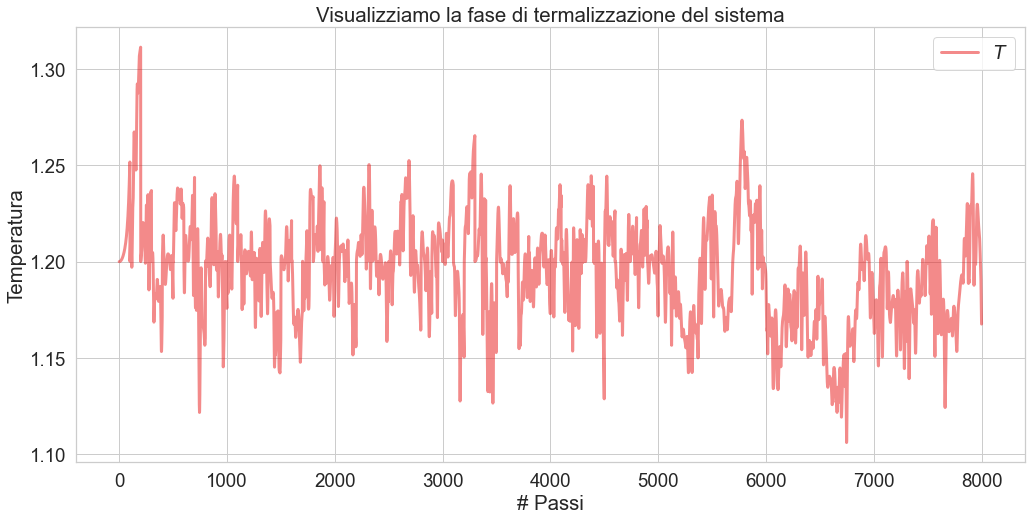

In [55]:
plt.figure(figsize=(17,8))
plt.title('Visualizziamo la fase di termalizzazione del sistema')
plt.plot()
plt.plot(temp, label='$T$', color='#e81717', linewidth=3, alpha=0.5)
#plt.hlines(1.2, 0, 11000, color='black', label='$T^*$', alpha=1, linestyle='--')
plt.legend()
plt.xlabel("# Passi")
plt.ylabel("Temperatura")
plt.savefig('therm.png')
#plt.xlim(100000, 110000)
plt.show()

In [60]:
ave_res.T[4]

array([1.42814, 1.42813, 1.42812, 1.42811, 1.42812, 1.42812, 1.42813,
       1.42813, 1.42813, 1.42813, 1.42813, 1.42812, 1.42812, 1.42812,
       1.42811, 1.42811, 1.42811, 1.42811, 1.42812, 1.42812, 1.42813,
       1.42813, 1.42814, 1.42814, 1.42814, 1.42815, 1.42815, 1.42815,
       1.42815, 1.42815, 1.42815, 1.42815, 1.42815, 1.42814, 1.42814,
       1.42814, 1.42813, 1.42813, 1.42812, 1.42812, 1.42812, 1.42811,
       1.42811, 1.42811, 1.42811, 1.42811, 1.4281 , 1.4281 , 1.4281 ,
       1.4281 , 1.4281 , 1.4281 , 1.42811, 1.42811, 1.42811, 1.42811,
       1.42811, 1.42811, 1.42811, 1.42811, 1.42811, 1.42811, 1.42812,
       1.42812, 1.42812, 1.42812, 1.42812, 1.42811, 1.42811, 1.42811,
       1.42811, 1.42811, 1.42811, 1.42811, 1.4281 , 1.4281 , 1.4281 ,
       1.4281 , 1.4281 , 1.4281 , 1.4281 , 1.4281 , 1.4281 , 1.4281 ,
       1.4281 , 1.4281 , 1.4281 , 1.4281 , 1.4281 , 1.4281 , 1.4281 ,
       1.4281 , 1.4281 , 1.4281 , 1.42811, 1.42811, 1.42811, 1.4281 ,
       1.4281 , 1.42

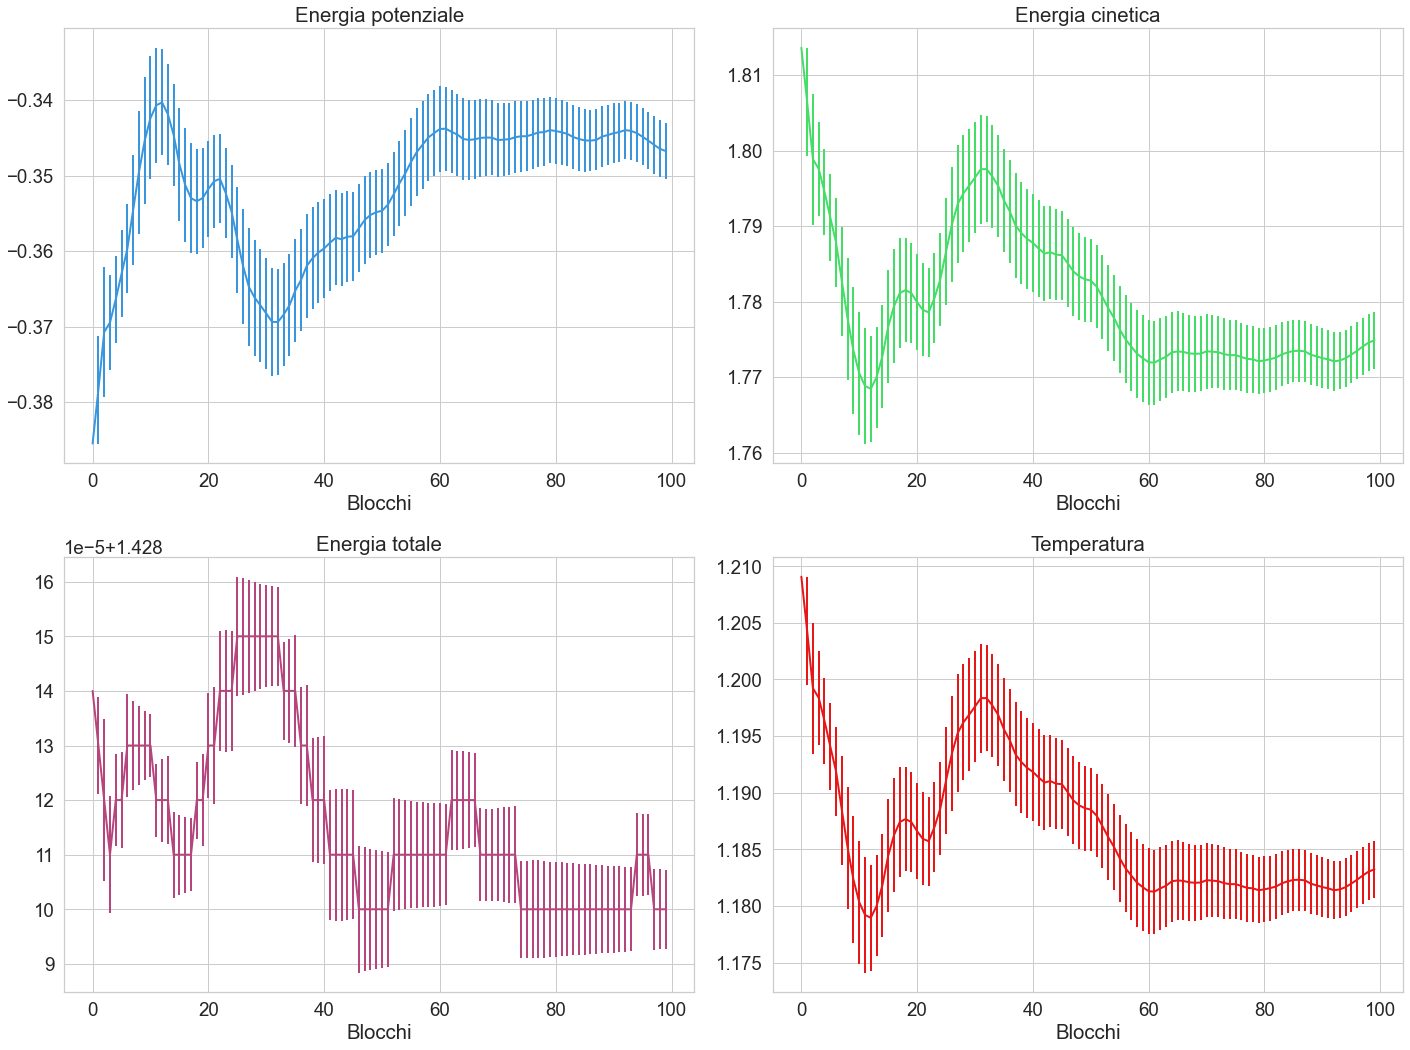

In [57]:
plt.figure(figsize=(20,15))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(titles[i])
    plt.errorbar(x, ave_res.T[i*2]*fs[i], yerr=ave_res.T[i*2+1]*fs[i], color=colors[i], alpha=1, linewidth=2)
    plt.xlabel('Blocchi')

plt.tight_layout()
plt.show()